In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import traceback

#PATH = Path('../data/mnist_kaggle/')
PATH = Path('../../data/mnist_kaggle/')
IMG_SIZE = 28

In [3]:
[x for x in PATH.iterdir()]

[PosixPath('../../data/mnist_kaggle/sample_submission.csv'),
 PosixPath('../../data/mnist_kaggle/test'),
 PosixPath('../../data/mnist_kaggle/models'),
 PosixPath('../../data/mnist_kaggle/train.csv'),
 PosixPath('../../data/mnist_kaggle/test.csv'),
 PosixPath('../../data/mnist_kaggle/train'),
 PosixPath('../../data/mnist_kaggle/tmp')]

In [3]:
test = pd.read_csv(filepath_or_buffer=PATH/'test.csv')
test.shape

(28000, 784)

In [4]:
all_train = pd.read_csv(filepath_or_buffer=PATH/'train.csv')
all_train.shape

(42000, 785)

In [5]:
val_ids = get_cv_idxs(all_train['label'].size)
train = all_train.drop(all_train.index[val_ids])
valid = all_train.iloc[val_ids]
train.shape, valid.shape

((33600, 785), (8400, 785))

In [24]:
n_channels = 3

In [40]:
train_y = np.array(train['label'])
train_x = np.repeat(np.array(train.iloc[:,1:]), n_channels, axis=1)
train_x = train_x.astype(np.float32)

valid_y = np.array(valid['label'])
valid_x = np.repeat(np.array(valid.iloc[:,1:]), n_channels, axis=1)
valid_x = valid_x.astype(np.float32)

In [41]:
train_x.shape, valid_x.shape

((33600, 2352), (8400, 2352))

In [42]:
train_x = train_x.reshape(train_x.shape[0], IMG_SIZE, IMG_SIZE, n_channels); train_x.shape

(33600, 28, 28, 3)

In [43]:
valid_x = valid_x.reshape(valid_x.shape[0], IMG_SIZE, IMG_SIZE, n_channels); valid_x.shape

(8400, 28, 28, 3)

In [45]:
test_x = np.repeat(np.array(test.iloc[:,0:]), n_channels, axis=1)
test_x = test_x.astype(np.float32)

test_x = test_x.reshape(test_x.shape[0], IMG_SIZE, IMG_SIZE, n_channels)
test_x.shape

(28000, 28, 28, 3)

In [67]:
?tfms_from_stats

In [46]:
arch=resnet34
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, IMG_SIZE, aug_tfms=[RandomFlip()], pad=IMG_SIZE//8)
data = ImageClassifierData.from_arrays(PATH, trn=(train_x, train_y), val=(valid_x, valid_y), test=test_x
                                       ,tfms=tfms
                                      )

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [32]:
lrf=learn.lr_find()

 83%|████████▎ | 436/525 [00:06<00:01, 68.51it/s, loss=3.17]


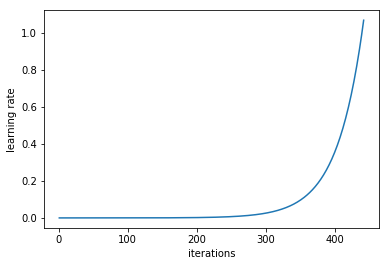

In [33]:
learn.sched.plot_lr()

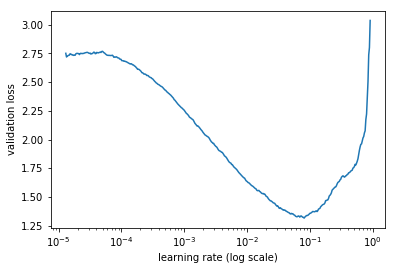

In [34]:
learn.sched.plot()

In [35]:
lr = 0.01

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 438/438 [00:09<00:00, 44.89it/s]


In [48]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.592607   0.510286   0.88869   



[array([0.51029]), 0.8886904761904761]

In [49]:
learn.precompute=False

In [50]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.113642   0.660958   0.799524  
    1      1.047569   0.641721   0.797262                   
    2      1.010233   0.632588   0.802024                    



[array([0.63259]), 0.8020238095238095]

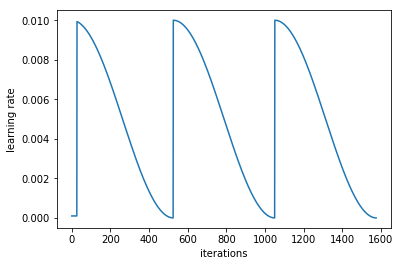

In [51]:
learn.sched.plot_lr()

In [52]:
learn.save('28_lastlayer')

In [53]:
learn.load('28_lastlayer')

In [54]:
learn.unfreeze()

In [55]:
lr=np.array([1e-4,1e-3,1e-2])

In [56]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.304391   0.189229   0.940238  
    1      0.192215   0.11261    0.96631                     
    2      0.180101   0.096554   0.969286                    
    3      0.141101   0.072277   0.977857                    
    4      0.114055   0.06298    0.979524                    
    5      0.099863   0.058006   0.981905                     
    6      0.094652   0.056786   0.982738                     



[array([0.05679]), 0.9827380952380952]

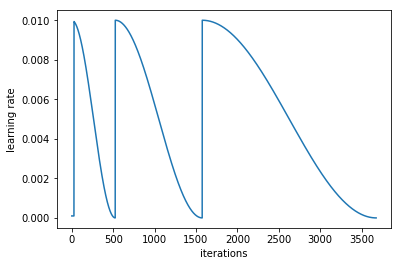

In [57]:
learn.sched.plot_lr()

In [58]:
learn.save('28_all')

In [59]:
learn.load('28_all')

In [60]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [61]:
accuracy_np(probs, y)
#0.9485714285714286

0.9860714285714286

In [99]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 3, 3]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 2, 2]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 2, 2]),
                           ('output_shape', [-1, 64, 1, 1]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 1, 1]),
                           (

In [62]:
data.classes

In [63]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)

In [64]:
probs.shape

(28000, 10)

In [65]:
df = pd.DataFrame(probs)

In [66]:
df['Label'] = df.idxmax(axis=1)

In [67]:
df.index += 1

In [68]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,Label
1,5.692401e-07,4.992755e-07,0.99798,0.001244,0.000007,0.00052,0.000037,0.00009,0.000116,0.000004,2


In [69]:
df.to_csv('subm.gz', columns=['Label'], compression='gzip', index_label='ImageId')

In [70]:
FileLink(f'subm.gz')

/home/paperspace/fastai/fastai_learn/subm.gz